In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

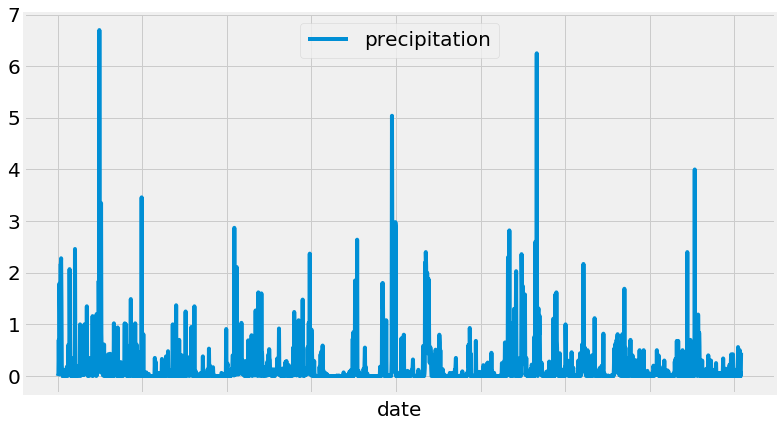

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date = dt.datetime.strptime(session.query(Measurement.date).order_by(Measurement.id.desc()).first()[0], '%Y-%m-%d')
last_year_date = max_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
perc_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
percp_df = pd.DataFrame(perc_data)
percp_df = percp_df.rename(columns={'prcp': 'precipitation'})
percp_df = percp_df.dropna()
percp_df = percp_df.set_index('date')

# Sort the dataframe by date
percp_df.sort_index(inplace=True, ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = percp_df.index.values
y_axis = percp_df['precipitation'].values
percp_df.plot(figsize=(12,7))
plt.xlabel('date', size = 20)
plt.legend(fontsize=20, loc='upper center')
plt.yticks(fontsize=20)
plt.show()

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
percp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.name).count()
print(station_count)

9


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station)).\
                    filter(Measurement.station == Station.station).group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
active_station_ls = list(active_station)
active_station_ls

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = active_station_ls[0][0]
temp_active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),\
                                    func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).\
                                    all()
                        
print(temp_active_station)

[(54.0, 85.0, 71.66378066378067)]


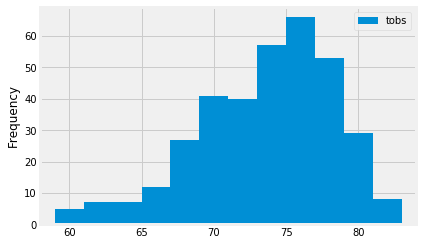

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
            filter(Measurement.date > last_year_date).filter(Measurement.station == most_active_station).\
            all()

# Save the query results as a Pandas DataFrame and set the index to the date column
tobs_df = pd.DataFrame(tobs_data)
plt.hist(tobs_df['tobs'], bins=range(55, 85,2))
plt.xlim(58, 84)
plt.ylabel("Frequency")
plt.legend(['tobs'])
plt.rc('font', size=10)

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
py_trip_start = '2017-03-01'
py_trip_end = '2017-03-05'

(tmin, tavg, tmax) = calc_temps(py_trip_start, py_trip_end)[0]
tmin, tavg, tmax

(64.0, 71.96551724137932, 78.0)

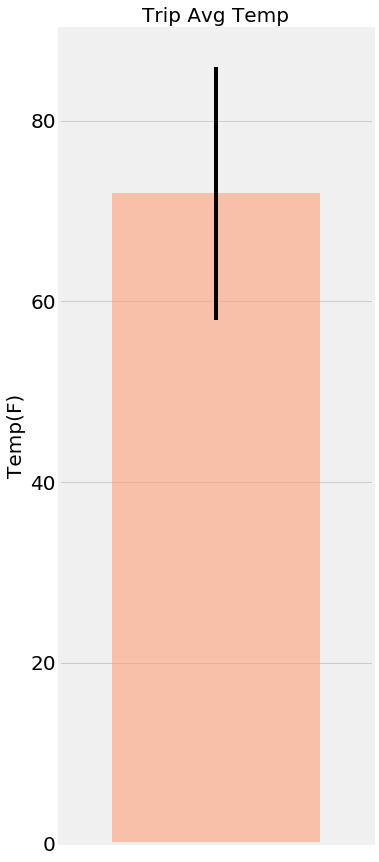

In [17]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(5,15))
plt.title("Trip Avg Temp", size = 20)
plt.ylabel("Temp(F)", size =20)
plt.bar(1, tavg, yerr = tmax-tmin, color ='lightsalmon', align = 'center', alpha=0.6)
plt.xlim(0.4,1.6)
plt.xticks([])
plt.yticks(fontsize=20)
plt.show()

In [18]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

active_station = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,\
                               Measurement.prcp).\
                    filter(Measurement.station == Station.station).\
                    filter(Measurement.date >= py_trip_start).filter(Measurement.date <= py_trip_end).\
                    order_by(Measurement.prcp.desc()).all()
print(list(active_station))

[('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2.4), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.2), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.12), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.0), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.88), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.48), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.45), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.19), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.12), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.73), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.59), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.58), ('USC00516128', 'MANOA LYON ARBO 785.2, HI U

## Optional Challenge Assignment

In [19]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [20]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
py_trip_start = dt.datetime.strptime('2018-01-01', '%Y-%m-%d')
py_trip_end = dt.datetime.strptime('2018-01-07', '%Y-%m-%d')

# Use the start and end date to create a range of dates
trip_dates = [py_trip_start + dt.timedelta(days=x) for x in range(0, (py_trip_end-py_trip_start).days +1)]

# Stip off the year and save a list of %m-%d strings
date_part = [x.strftime('%m-%d') for x in trip_dates]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normal_ls = []
for dt_part in date_part:
    print(daily_normals(dt_part))
    daily_normal_ls.append(daily_normals(dt_part)[0])

[(62.0, 69.15384615384616, 77.0)]
[(60.0, 69.39622641509433, 77.0)]
[(62.0, 68.9090909090909, 77.0)]
[(58.0, 70.0, 76.0)]
[(56.0, 67.96428571428571, 76.0)]
[(61.0, 68.96491228070175, 76.0)]
[(57.0, 68.54385964912281, 76.0)]


In [21]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

df_daily_normal = pd.DataFrame(daily_normal_ls, columns=['tmin', 'tavg', 'tmax'])
df_daily_normal["date"] = trip_dates
df_daily_normal = df_daily_normal.set_index('date')
df_daily_normal.head()

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


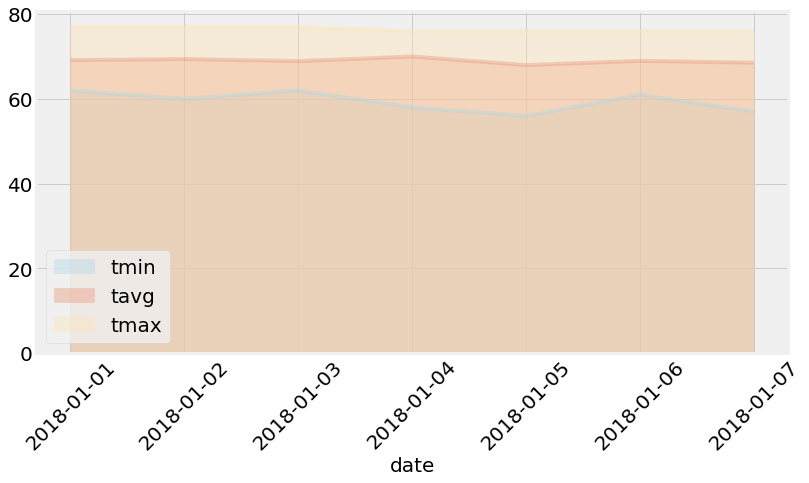

In [22]:
fig,ax = plt.subplots()
df_daily_normal.plot(kind='area', x_compat=True,ax=ax, stacked=False, alpha=0.4, \
                     color=['lightblue', 'darksalmon', 'moccasin'], figsize=(12,7))

ax.xaxis.set_tick_params(reset=True)
plt.xlabel("date",size =20)
plt.xticks(fontsize=20 , rotation=45)
plt.yticks(fontsize=20)
plt.yticks(np.arange(0, 100, 20))
plt.legend(fontsize=20)
plt.show()